In [1]:
from helpers.utils import Utils

import matplotlib.pyplot as plt
from models.peer import Peer

%config InlineBackend.figure_format = 'retina'

In [2]:
use_snapshot = True
default_snapshot = "2024_04_23"
min_version = "2.0.7"


In [3]:
peers, safes, topology = Utils.loadSnapshot(default_snapshot, "peers", "safes", "topology")
eligibles = Utils.getEligiblesPeers(topology, peers, safes, min_version)

print(f"Subgraph size: {len(safes)}")
print(f"Topology size: {len(topology)}" )
print(f"Number of peers: {len(peers)}")

Subgraph size: 839
Topology size: 507
Number of peers: 376


peers_in_limits=247


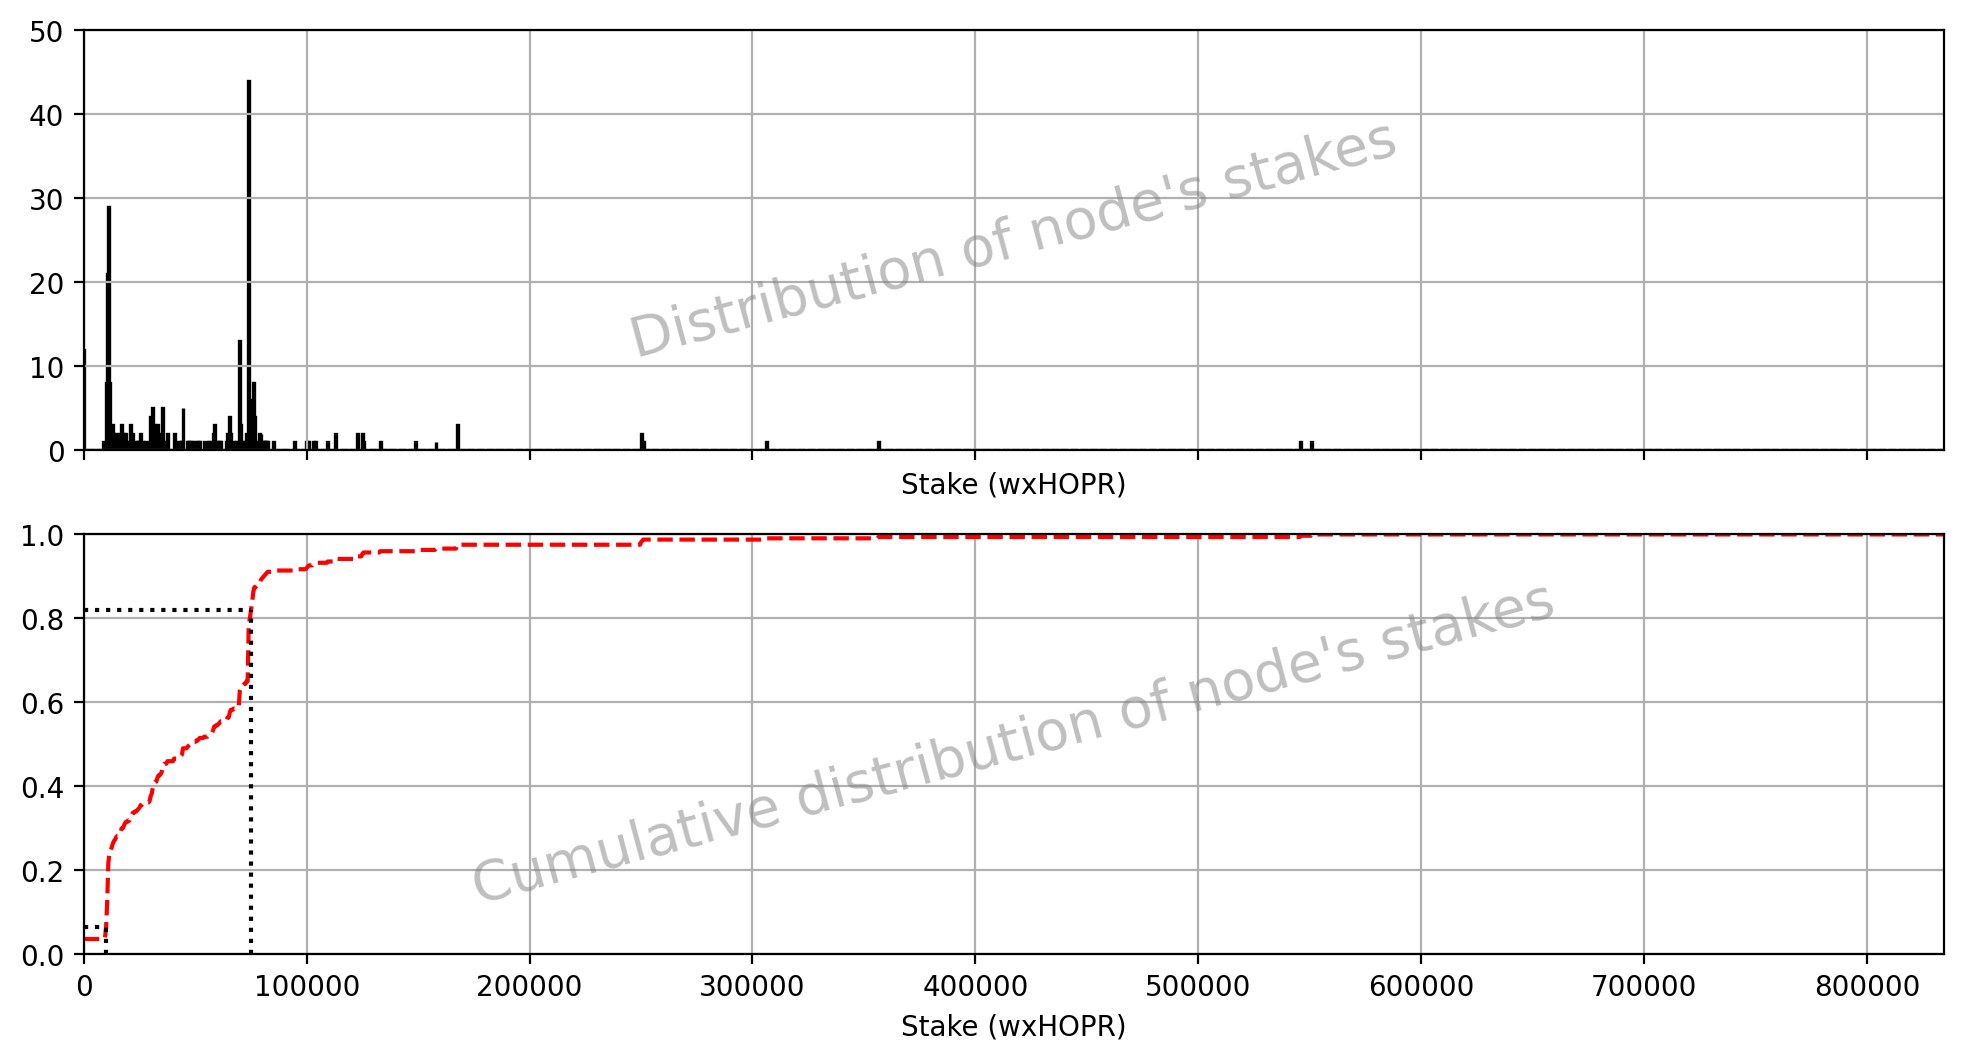

In [4]:
def plot_histogram(ax: plt.Axes, peers: list[Peer], bin: list[int], round_multiple: float=20.0, watermark: str = ""):
    # plot
    stakes = [peer.split_stake for peer in peers]
    counts, _, _ = ax.hist(stakes, 
                           bins=bin, facecolor="#000050", edgecolor='black', 
                           linewidth=1.2, rwidth=.85)
    bin_centers = [(left + right) * 0.5 for left, right in zip(bin[:-1], bin[1:]) ]

    max_height = max(round(counts.max() / round_multiple + .5) * round_multiple, 1)

    # settings
    ax.set_xlim(bin[0], bin[-1])
    ax.set_ylim(0, max_height)
    ax.set_xlabel("Stake (wxHOPR)")
    ax.grid()

    ax.text(0.5, 0.5, watermark, transform=ax.transAxes,
        fontsize=20, color='gray', alpha=0.5,
        ha='center', va='center', rotation=15)
    
    return counts, bin_centers

def plot_cumsum(ax: plt.Axes, counts: list[int], bin_centers: list[float], limits: list[int], watermark: str):
    cumsum = counts.cumsum()/sum(counts)
    ax.plot(bin_centers, cumsum, 'r--', linewidth=1.5)
    ax.set_xlim(bin_centers[0], bin_centers[-1])
    ax.set_ylim(0, cumsum.max())
    ax.set_xlabel("Stake (wxHOPR)")
    ax.grid()

    ax.text(0.5, 0.5, watermark, transform=ax.transAxes,
        fontsize=20, color='gray', alpha=0.5,
        ha='center', va='center', rotation=15)

    cumsums_at_limits = [cumsum[bin_centers.index(pos)] for pos in limits]
    for x, y in zip(limits, cumsums_at_limits):
        ax.vlines(x, 0, y, colors='black', linestyles='dotted')
        ax.hlines(y, 0, x, colors='black', linestyles='dotted')

    return cumsums_at_limits

filtered = list(filter(lambda peer: peer.split_stake <= 2e6, eligibles))
max_stake = int(max([peer.split_stake for peer in filtered]))
limits = [10e3, 75e3]
bin_step = 500

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
counts, bin_centers = plot_histogram(axes[0], filtered, list(range(-bin_step//2, max_stake, bin_step)), 10,"Distribution of node's stakes")
cumsum_at_limits = plot_cumsum(axes[1], counts, bin_centers, limits, "Cumulative distribution of node's stakes")

peers_in_limits = round((cumsum_at_limits[1]-cumsum_at_limits[0])*len(filtered))
print(f"{peers_in_limits=}")